In [1]:
!pip install --upgrade matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed

In [3]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [4]:
btc_stocks = pd.read_csv('btcStocks.csv', index_col=0)
eth_stocks = pd.read_csv('ethStocks.csv', index_col=0)
ada_stocks = pd.read_csv('adaStocks.csv', index_col=0)

btc_new_stocks = pd.read_csv('btcActualStocks.csv', index_col=0)
eth_new_stocks = pd.read_csv('ethActualStocks.csv', index_col=0)
ada_new_stocks = pd.read_csv('adaActualStocks.csv', index_col=0)

In [5]:
btc_stocks.head()

,btcClose
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [6]:
btc_new_stocks.head()

,btcClose
date,
2021-07-13,32702.025391
2021-07-14,32822.347656
2021-07-15,31780.730469
2021-07-16,31421.539063
2021-07-17,31533.068359


In [7]:
eth_stocks.head()

,ethClose
date,
2015-08-07,2.772120
2015-08-08,0.753325
2015-08-09,0.701897
2015-08-10,0.708448
2015-08-11,1.067860


In [8]:
eth_new_stocks.head()

,ethClose
date,
2021-07-13,1940.083984
2021-07-14,1994.331299
2021-07-15,1911.175659
2021-07-16,1880.382935
2021-07-17,1898.825195


In [9]:
ada_stocks.head()

,adaClose
date,
2017-10-01,0.024969
2017-10-02,0.025932
2017-10-03,0.020816
2017-10-04,0.021931
2017-10-05,0.021489


In [10]:
ada_new_stocks.head()

,adaClose
date,
2021-07-13,1.265083
2021-07-14,1.262258
2021-07-15,1.223192
2021-07-16,1.173715
2021-07-17,1.172302


In [11]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :][last_training_predictions_df.columns[1]] < row[last_training_predictions_df.columns[1]], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, train_ts, test_ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16, full_test=False):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  print('Training on train_ts')
  # This line is to replicate the other script

  model.train(train_ts, n_epochs, batch_size)

  print('Iteration 1 started on test')
  steps_to_predict = test_ts[:n_steps]
  steps_result = test_ts[n_steps:n_steps+n_test]
  if full_test:
    i=1
    while n_steps + (n_test * i) < len(test_ts):
      predictions = model.predict(steps_to_predict)
      predictions = predictions.reshape(predictions.shape[1])
      predictions_ts = pd.DataFrame({steps_result.columns[0]: predictions}, steps_result.index)

      predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
      predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

      test_df = build_prediction_dataframe(steps_to_predict, steps_result)
      test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

      predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
      predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
      predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

      hits = predictions_and_test['equal'].sum()
      print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
      total_hits += hits
      total_tries += predictions_and_test.shape[0]

      print('Iteration {} started'.format(i))
      new_train = pd.concat([steps_to_predict, steps_result])
      model.train(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
      steps_to_predict = test_ts[(n_test * (i-1)):n_steps + (n_test * (i-1))]
      steps_result = test_ts[n_steps + (n_test * (i-1)):n_steps + (n_test * i)]
      i+=1
  else:
    for i in reversed(range(1, n_evaluations + 1)):
      print('Last training {} {}'.format(i, steps_to_predict))
      predictions = model.predict(steps_to_predict)
      predictions = predictions.reshape(predictions.shape[1])
      predictions_ts = pd.DataFrame({'close': predictions}, test_evaluate.index)
      
      predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
      predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)
      
      test_df = build_prediction_dataframe(steps_to_predict, steps_result)
      test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

      predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
      predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
      predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

      hits = predictions_and_test['equal'].sum()
      print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
      total_hits += hits
      total_tries += predictions_and_test.shape[0]

      print('Iteration {} started'.format(n_evaluations + 1 - i))
      new_train = pd.concat([steps_to_predict, test_evaluate])
      model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
      steps_to_predict = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [12]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

In [13]:
from VanillaLSTM import VanillaLSTM
from StackedLSTM import StackedLSTM
from BidirectionalLSTM import BidirectionalLSTM
from ConvLSTM import ConvLSTM
from CnnLSTM import CnnLSTM

epochs = 30
batch_size = 16
n_steps = 6
n_outputs = 3
n_evaluations = 10
n_neurons = 40
n_seed = 500
optimizer = 'adam'
loss = 'mean_squared_error'
model_type = CnnLSTM

seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks, btc_new_stocks, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 40)                27040     
_________________________________________________________________
dense (Dense)                (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
140/140 [==============================] - 2s 5ms/step - loss: 0.0021 - accuracy:

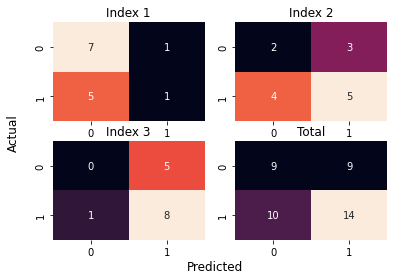

In [14]:
plot_confusion_matrix(cm)

In [15]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks, eth_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
140/140 [==============================] - 2s 4ms/step - loss: 0.0021 - accurac

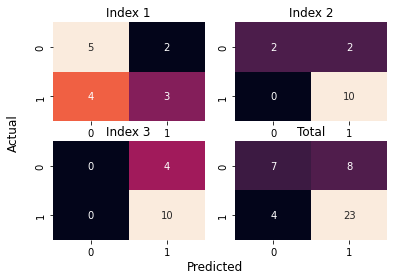

In [16]:
plot_confusion_matrix(cm)

In [17]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks, ada_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
140/140 [==============================] - 2s 4ms/step - loss: 0.0021 - accurac

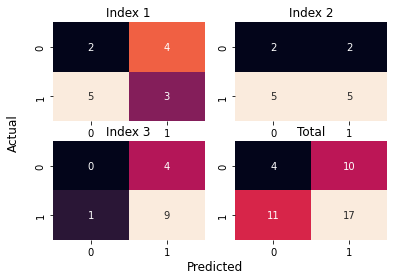

In [18]:
plot_confusion_matrix(cm)

In [19]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks, btc_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
122/122 [==============================] - 2s 5ms/step - loss: 0.0017 - accurac

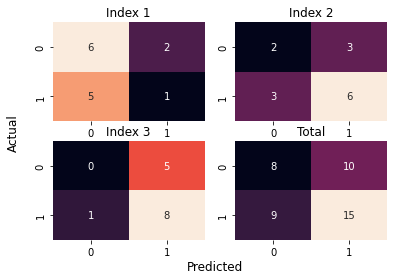

In [20]:
plot_confusion_matrix(cm)

In [21]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks, eth_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
122/122 [==============================] - 2s 5ms/step - loss: 0.0017 - accurac

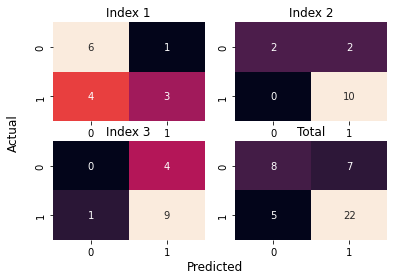

In [22]:
plot_confusion_matrix(cm)

In [23]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks, ada_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
122/122 [==============================] - 2s 5ms/step - loss: 0.0017 - accurac

In [24]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks, btc_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
78/78 [==============================] - 2s 6ms/step - loss: 0.0044 - accuracy:

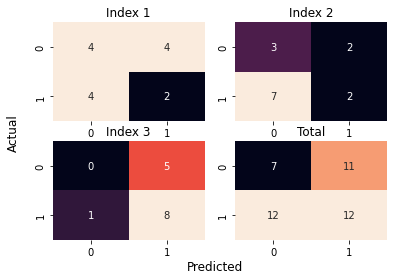

In [25]:
plot_confusion_matrix(cm)

In [26]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks, eth_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
78/78 [==============================] - 2s 6ms/step - loss: 0.0044 - accuracy:

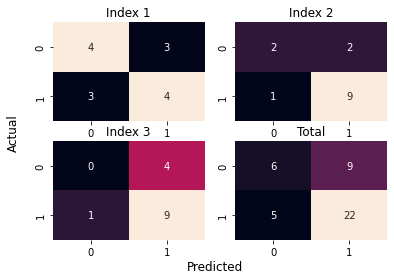

In [27]:
plot_confusion_matrix(cm)

In [28]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks, ada_new_stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, None, 5, 64)       192       
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                27040     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 123       
Total params: 27,355
Trainable params: 27,355
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/30
78/78 [==============================] - 2s 6ms/step - loss: 0.0044 - accuracy:

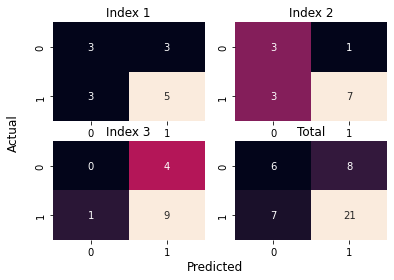

In [29]:
plot_confusion_matrix(cm)